In [29]:
import numpy as np, pandas as pd

In [30]:
import warnings

warnings.filterwarnings('ignore')

In [31]:
X = np.random.normal(loc=0, scale=1, size=1000)
Z = 2*X + np.random.normal(loc=0, scale=1, size=1000)
Y = 2*X + 3*Z + np.random.normal(loc=0, scale=1, size=1000)
df = pd.DataFrame(data=dict(X=X, Y=Y, Z=Z))

In [32]:
gml_string = """
graph [directed 1
    node [
      id 0
      label "X"
    ]
    node [
      id 1
      label "Z"
    ]
    node [
      id 2
      label "Y"
    ]
    edge [
    source 0
    target 1
    ]
    edge [
    source 0
    target 2
    ]
    edge [
    source 1
    target 2
    ]
]
"""

In [33]:
from dowhy import CausalModel

model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
    )

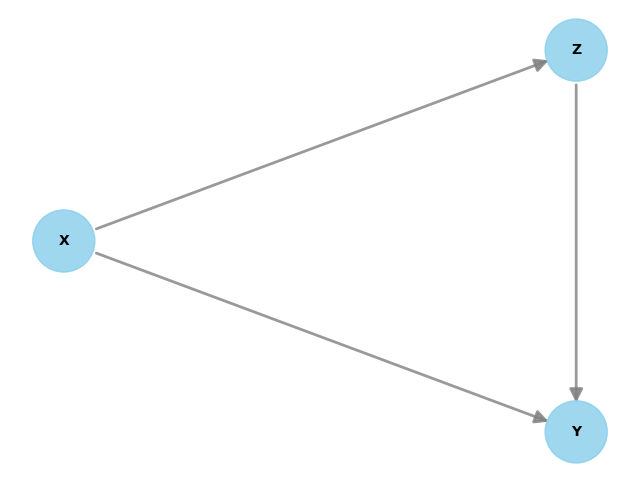

In [34]:
model.view_model()

$
Z = 2 \times X \\
Y = 2 \times X + 3 \times Z = 2 \times X + 6 \times X = 8 \times X
$

+ Direct effect ($X \rightarrow Y$): $2$
+ Indirect effect ($X \rightarrow Z \rightarrow Y$): $6$
+ Total effect: $8$

# Direct and indirect effects

## Identification

In [35]:
# Natural direct effect (nde)
identified_estimand_nde = model.identify_effect(estimand_type="nonparametric-nde",
                                                proceed_when_unidentifiable=True)
print(identified_estimand_nde)

Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡ d       ⎤
E⎢────(Y|Z)⎥
 ⎣d[X]     ⎦
Estimand assumption 1, Mediation: Z intercepts (blocks) all directed paths from X to Y except the path {X}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



In [36]:
# Natural indirect effect (nie)
identified_estimand_nie = model.identify_effect(estimand_type="nonparametric-nie",
                                           proceed_when_unidentifiable=True)
print(identified_estimand_nie)

Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Mediation: Z intercepts (blocks) all directed paths from X to Y except the path {X}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



## Estimation

In [44]:
import dowhy.causal_estimators.linear_regression_estimator

causal_estimate_nie = model.estimate_effect(identified_estimand_nie,
                                            method_name="mediation.two_stage_regression",
                                            confidence_intervals=True,
                                            test_significance=False,
                                            method_params = {
                                                'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                                'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                                }
                                            )
print(causal_estimate_nie)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Mediation: Z intercepts (blocks) all directed paths from X to Y except the path {X}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

## Realized estimand
(b: Z~X)*(b: Y~Z+X)
Target units: ate

## Estimate
Mean value: 6.058192029886622
95.0% confidence interval: (5.853676342062071, 6.299797180043858)



In [45]:
causal_estimate_nde = model.estimate_effect(identified_estimand_nde,
                                            method_name="mediation.two_stage_regression",
                                            confidence_intervals=True,
                                            test_significance=False,
                                            method_params = {
                                                'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                                'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                                }
                                            )
print(causal_estimate_nde)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡ d       ⎤
E⎢────(Y|Z)⎥
 ⎣d[X]     ⎦
Estimand assumption 1, Mediation: Z intercepts (blocks) all directed paths from X to Y except the path {X}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

## Realized estimand
(b: Y~X) - ((b: Z~X)*(b: Y~Z+X))
Target units: ate

## Estimate
Mean value: 1.9614284055822369
95.0% confidence interval: (1.8353819995016076, 2.1096343041963683)



# Total effect

In [39]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [46]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression',
    confidence_intervals=True,
    )

In [47]:
print(f'Estimate of causal effect (Linear Regression): {estimate.value}')

Estimate of causal effect (Linear Regression): 8.019620435468859


In [48]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

## Realized estimand
b: Y~X
Target units: ate

## Estimate
Mean value: 8.019620435468859
95.0% confidence interval: [[7.8235059  8.21573497]]

